In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from tensorflow.keras import layers
from glob import glob
import gc

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 5.2 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2
import os
import timm
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time
from PIL import Image 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = sorted(glob('/content/gdrive/My Drive/Colab/train/train/*.png'))
test = sorted(glob('/content/gdrive/My Drive/Colab/test/test/*.png'))

In [ ]:
train_y = pd.read_csv("/content/gdrive/My Drive/Colab/train_df.csv")

In [ ]:
heavy = ['transistor', 'wood', 'screw', 'cable', 'carpet', 'hazelnut', 'grid']
mild = ['capsule', 'bottle', 'pill', 'metal', 'zipper', 'leather', 'tile']
exception = ['toothbrush']

In [ ]:
train_y = train_y.iloc[:,1:]

In [ ]:
train_y_balanced = pd.DataFrame(columns=train_y.columns)

In [ ]:
import random

In [ ]:
for i in range(len(train)):
  for j in exception:
    if train_y['label'][i].startswith(j):
      train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])

In [ ]:
for i in range(len(train)):
  for j in mild:
    if train_y['label'][i].startswith(j):
      if train_y['label'][i].endswith('-good'):
        if random.random()<0.5:
          train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])
      else:
        train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])
        train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])
        train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])

In [ ]:
for i in range(len(train)):
  for j in heavy:
    if train_y['label'][i].startswith(j):
      if train_y['label'][i].endswith('-good'):
        if random.random()<0.5:
          train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])
      else:
        train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])
        train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])
        train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])
        train_y_balanced = train_y_balanced.append(train_y.iloc[i,:])

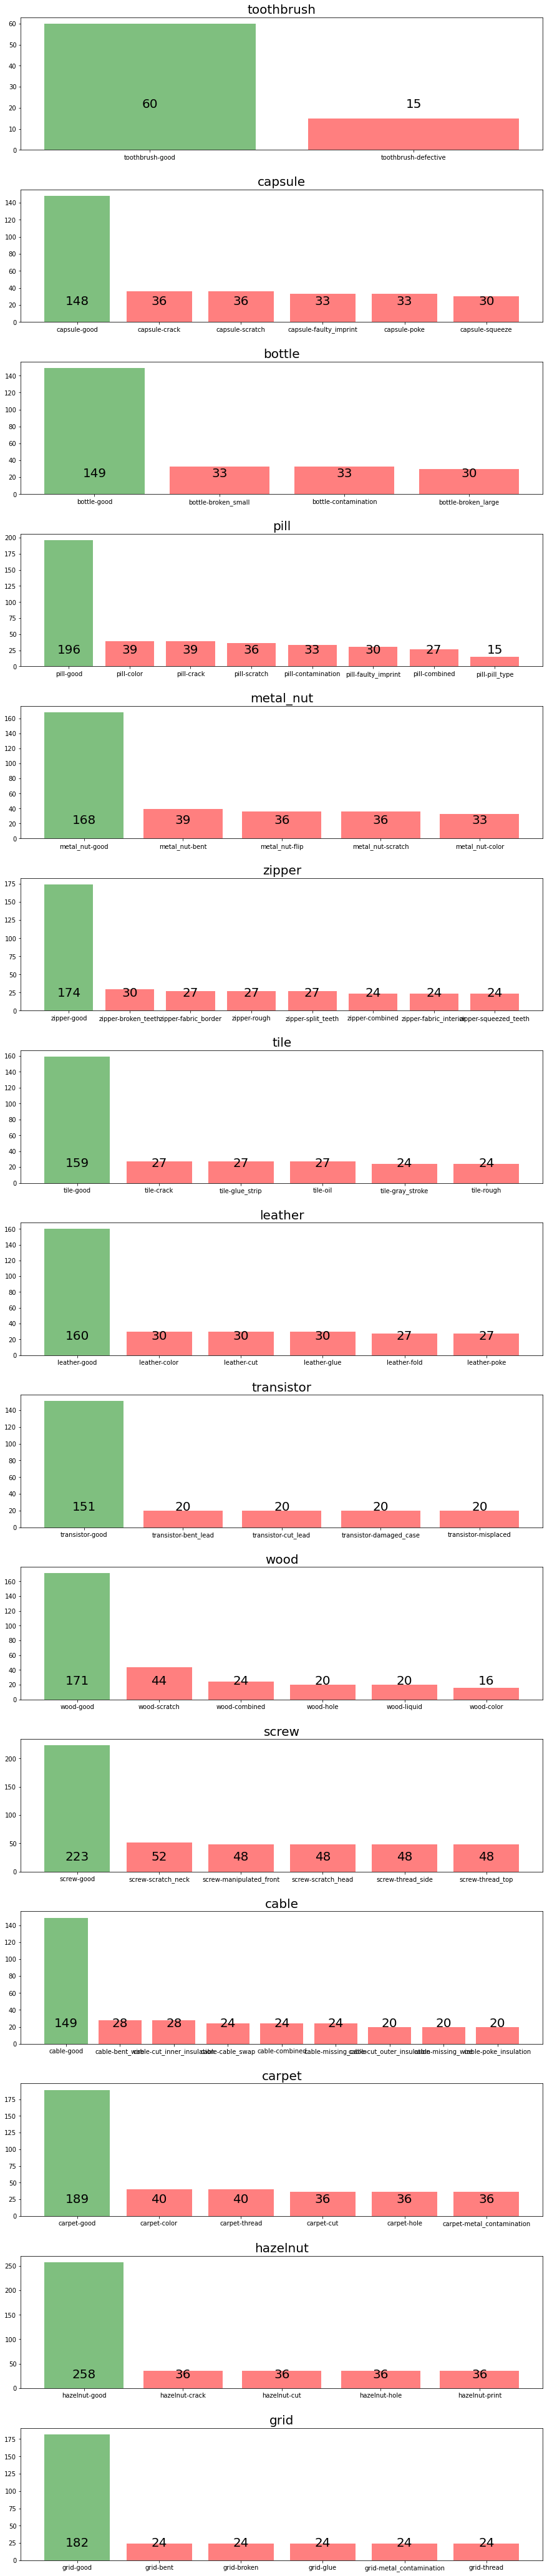

In [ ]:
classList = train_y_balanced['class'].unique()
labelList = train_y_balanced['label'].unique()
labelCount = train_y_balanced[['class', 'label']].groupby('label').count().rename(columns={'class': 'count'})
anomaly_dict = {}
for className in classList:
    df = pd.DataFrame(labelCount[labelCount.index.str.contains(className)]).sort_values(by='count', ascending=False)
    anomaly_dict[className] = df
fig, axs = plt.subplots(15, 1, figsize=(15, 15*5))
fig.subplots_adjust(hspace = .3)
axs = axs.ravel()

for i, (className, df) in enumerate(anomaly_dict.items()):
    colors = ['red' for i in range(len(df.index))]
    colors[0] = 'green'
    axs[i].bar(df.index, df.iloc[:, 0], color=colors, alpha=0.5)
    axs[i].set_title(className, fontsize=20)
    for j, value in enumerate(df.iloc[:, 0]):
        axs[i].text(j, 20, df.iloc[:, 0][j], ha='center', fontsize=20)

In [ ]:
train_labels = train_y_balanced["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

In [ ]:
from torchvision.transforms.transforms import RandomCrop
import torchvision
import torchvision.transforms as transforms

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512))
])

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90, expand=False),
    transforms.RandomResizedCrop(size=512, scale=(0.7, 1))
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.2)
])

In [ ]:
train_list = []
for i in train_y_balanced['file_name']:
  train_list.append("/content/gdrive/My Drive/anomaly/train/{}".format(i))

In [ ]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (512, 512))
    return img

train_imgs = [img_load(m) for m in tqdm(train_list)]
test_imgs = [img_load(n) for n in tqdm(test)]

100%|██████████| 2154/2154 [01:26<00:00, 24.79it/s]


In [ ]:
del train
del test

In [ ]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train', transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx] 
        img = Image.open(img_path)

        if self.transform is not None: 
            if self.mode=='train':               
                img = transform(img)
                if img.size()[0] ==1 :
                  img = torch.stack((img,img,img)).squeeze()
               
        else:
            if self.mode=='test':
                transformm = transforms.Compose([
                    transforms.Resize((512,512)),
                    transforms.ToTensor(),
                ])
                img = transformm(img)
                if img.size()[0] ==1 :
                  img = torch.stack((img,img,img)).squeeze()

        label = self.labels[idx]
        return img, label

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b2', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
batch_size = 32

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
del train_imgs

In [ ]:
# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
del test_imgs

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda')

In [ ]:
net = Network().to("cuda:0")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
scaler = torch.cuda.amp.GradScaler() 



best=0
epochs = 25
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        gc.collect()
        torch.cuda.empty_cache()
        
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

epoch : 1/25    time : 731s/17551s
TRAIN    loss : 1.23063    f1 : 0.34579
epoch : 2/25    time : 731s/16815s
TRAIN    loss : 0.46004    f1 : 0.62503
epoch : 3/25    time : 733s/16130s
TRAIN    loss : 0.26651    f1 : 0.76782
epoch : 4/25    time : 719s/15100s
TRAIN    loss : 0.19141    f1 : 0.81447


In [ ]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

In [ ]:
submission = pd.read_csv("/content/gdrive/My Drive/anomaly/sample_submission.csv")

submission["label"] = f_result

submission

In [ ]:
submission.to_csv("/content/gdrive/My Drive/anomaly/third_trial.csv", index = False)